<a href="https://colab.research.google.com/github/deeptika/link_spam/blob/master/LINK_SPAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Big Data Analytics Project**


---

By:

Deeptika Kannan

121014015

B.Tech. ICT 4th year

In [ ]:
#loading all required data

!git clone https://github.com/deeptika/link_spam.git

Cloning into 'link_spam'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 4), reused 21 (delta 2), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
#importing all libraries

#essential libraries
import pandas as pd
import numpy as np
import math

#for visualization
import matplotlib.pyplot as plt

#for network building
import networkx as nx
from networkx.algorithms.reciprocity import reciprocity
from networkx.algorithms.link_analysis.pagerank_alg import pagerank
from networkx.algorithms.centrality import eigenvector_centrality, betweenness_centrality
from networkx.algorithms.assortativity import average_neighbor_degree
from networkx.algorithms.cluster import triangles, clustering

#for ML models
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# Phase 1 - Link spam Classification

In [ ]:
#reading all data files

hostnames_file = "link_spam/webspam-uk2007-set1-1.0/WEBSPAM-UK2007-hostnames.txt"
with open(hostnames_file, 'r') as f:
			hostnames_data = f.readlines()

labels_train_file = "link_spam/webspam-uk2007-set1-1.0/WEBSPAM-UK2007-SET1-labels.txt"
with open(labels_train_file, 'r') as f:
  labels_train_data = f.readlines()

labels_test_file = "link_spam/webspam-uk2007-set2-1.0/WEBSPAM-UK2007-SET2-labels.txt"
with open(labels_test_file, 'r') as f:
  labels_test_data = f.readlines()

hosts_graph_file = "link_spam/uk-2007-05.hostgraph_weighted.txt"
with open(hosts_graph_file, 'r') as f:
  hosts_graph_data = f.readlines()

##Loading the data

In [ ]:
#reading dataset of hostnames
hostname_df = pd.DataFrame()
hostid = []
hostname = []

for line in hostnames_data:
  line = line.partition(" ")
  hostid.append(line[0])
  hostname.append(line[-1].partition("\n")[0])

hostname_df['Host ID'] = hostid
hostname_df['Host Name'] = hostname

hostname_df.head()

,Host ID,Host Name
0,0,0800.loan-line.co.uk
1,1,1-2clacton.boys-brigade.org.uk
2,2,1-hydroponics.co.uk
3,3,102belfast.boys-brigade.org.uk
4,4,109belfast.boys-brigade.org.uk


In [ ]:
#reading train data
labels_train_df = pd.DataFrame()
hostid = []
label = []

for line in labels_train_data:
  line = line.split(" ")
  hostid.append(line[0])
  label.append(line[1])

labels_train_df['Host ID'] = hostid
labels_train_df['Label'] = label

labels_train_df.head()

,Host ID,Label
0,4,nonspam
1,5,nonspam
2,8,nonspam
3,61,nonspam
4,62,nonspam


In [ ]:
#reading test data
labels_test_df = pd.DataFrame()
hostid = []
label = []

for line in labels_test_data:
  line = line.split(" ")
  hostid.append(line[0])
  label.append(line[1]) #use split

labels_test_df['Host ID'] = hostid
labels_test_df['Label'] = label

labels_test_df.head()

,Host ID,Label
0,182,nonspam
1,262,nonspam
2,327,nonspam
3,377,nonspam
4,418,nonspam


In [ ]:
#reading hosts web graph data

#first line of hosts_graph_data contains the number of hosts we are dealing with
num_hosts = int(hosts_graph_data[0].partition("\n")[0])
print("Number of hosts = {}".format(num_hosts))
hosts_graph_data = hosts_graph_data[1:]

Number of hosts = 114529


##Graph Construction

In [ ]:
#subsequent lines contain outlinks from various hosts; first line contains the outlinks of host 0 to various other hosts along with number of links; starting from host 0

edge_list = []
for i in range(num_hosts):
  line = hosts_graph_data[i]
  if(line == '\n'):
    continue
  line = line.split(" ")
  line[-1] = line[-1].partition("\n")[0]
  for stat in line:
    stat = list(map(int, stat.split(":")))
    edge_list.append((i, stat[0], stat[1]))

#constructing graph
g = nx.DiGraph()
g.add_nodes_from([x for x in range(num_hosts)])
keys = g.add_weighted_edges_from(edge_list)
print("Graph with {} nodes and {} edges, all of them labelled (spam/non-spam/undecided), is formed".format(len(g.nodes), len(g.edges)))

Graph with 114529 nodes and 1836441 edges, all of them labelled (spam/non-spam/undecided), is formed


In [ ]:
#forming a dataframe for graph related features of the given network

hosts_graph_df = pd.DataFrame()
hosts_graph_df['Host ID'] = [x for x in g.nodes]
hosts_graph_df.head()

,Host ID
0,0
1,1
2,2
3,3
4,4


In [ ]:
#adding columns for indegree and outdegree of each node
indegree = []
outdegree = []

for node in g.in_degree(weight='weight'):
  indegree.append(node[1])

for node in g.out_degree(weight='weight'):
  outdegree.append(node[1])

hosts_graph_df["In Degree"] = indegree
hosts_graph_df["Out Degree"] = outdegree

hosts_graph_df.head()

,Host ID,In Degree,Out Degree
0,0,26,344
1,1,5,0
2,2,3,3325
3,3,6,1
4,4,4,1


In [ ]:
#adding a column for edge reciprocity
#skipping for now

hosts_graph_df['Edge Reciprocity'] = list(reciprocity(g, g.nodes).values())
hosts_graph_df.head()

,Host ID,In Degree,Out Degree,Edge Reciprocity
0,0,26,344,0.000000
1,1,5,0,0.000000
2,2,3,3325,0.000000
3,3,6,1,0.285714
4,4,4,1,0.400000


In [ ]:
#adding a column for pagerank

hosts_graph_df['PageRank'] = list(pagerank(g, weight='weight').values())
hosts_graph_df.head()

,Host ID,In Degree,Out Degree,Edge Reciprocity,PageRank
0,0,26,344,0.000000,0.000003
1,1,5,0,0.000000,0.000004
2,2,3,3325,0.000000,0.000003
3,3,6,1,0.285714,0.000004
4,4,4,1,0.400000,0.000004


In [ ]:
#different centrality measures methods for weighted networks
def degree_centrality(G):
  if len(G) <= 1:
    return {n: 1 for n in G}
  s = 1.0 / (len(G) - 1.0)
  centrality = {n: d * s for n, d in G.degree(weight='weight')}
  return centrality

def in_degree_centrality(G):
  if len(G) <= 1:
    return {n: 1 for n in G}
  s = 1.0 / (len(G) - 1.0)
  centrality = {n: d * s for n, d in G.in_degree(weight='weight')}
  return centrality

def out_degree_centrality(G):
  if len(G) <= 1:
    return {n: 1 for n in G}
  s = 1.0 / (len(G) - 1.0)
  centrality = {n: d * s for n, d in G.out_degree(weight='weight')}
  return centrality

In [ ]:
#adding columns for centrality, in degree centrality and out degree centrality

hosts_graph_df['Centrality'] = list(degree_centrality(g).values())
hosts_graph_df['In Degree Centrality'] = list(in_degree_centrality(g).values())
hosts_graph_df['Out Degree Centrality'] = list(out_degree_centrality(g).values())
hosts_graph_df.head()

,Host ID,In Degree,Out Degree,Edge Reciprocity,PageRank,Centrality,In Degree Centrality,Out Degree Centrality
0,0,26,344,0.000000,0.000003,0.003231,0.000227,0.003004
1,1,5,0,0.000000,0.000004,0.000044,0.000044,0.000000
2,2,3,3325,0.000000,0.000003,0.029058,0.000026,0.029032
3,3,6,1,0.285714,0.000004,0.000061,0.000052,0.000009
4,4,4,1,0.400000,0.000004,0.000044,0.000035,0.000009


In [ ]:
#adding column for eigenvector centrality

hosts_graph_df['Eigenvector Centrality'] = list(eigenvector_centrality(g, weight='weight').values())
hosts_graph_df.head()

,Host ID,In Degree,Out Degree,Edge Reciprocity,PageRank,Centrality,In Degree Centrality,Out Degree Centrality,Eigenvector Centrality
0,0,26,344,0.000000,0.000003,0.003231,0.000227,0.003004,5.648320e-14
1,1,5,0,0.000000,0.000004,0.000044,0.000044,0.000000,2.152469e-17
2,2,3,3325,0.000000,0.000003,0.029058,0.000026,0.029032,3.765439e-15
3,3,6,1,0.285714,0.000004,0.000061,0.000052,0.000009,3.917377e-17
4,4,4,1,0.400000,0.000004,0.000044,0.000035,0.000009,2.152465e-17


In [ ]:
'''
hosts_graph_df['Betweenness Centrality'] = list(betweenness_centrality(g, weight='weight').values())
triangles(g.to_undirected())
clustering(g, weight='weight')
'''

In [ ]:
#adding column for assortavity - average degree of neighbours

hosts_graph_df['Assortavity'] = list(average_neighbor_degree(g, weight='weight').values())
hosts_graph_df.head()

,Host ID,In Degree,Out Degree,PageRank,Centrality,In Degree Centrality,Out Degree Centrality,Eigenvector Centrality,Assortavity
0,0,26,344,0.000003,0.003231,0.000227,0.003004,5.648320e-14,56.226744
1,1,5,0,0.000004,0.000044,0.000044,0.000000,2.152469e-17,0.000000
2,2,3,3325,0.000003,0.029058,0.000026,0.029032,3.765439e-15,2.005113
3,3,6,1,0.000004,0.000061,0.000052,0.000009,3.917377e-17,289.000000
4,4,4,1,0.000004,0.000044,0.000035,0.000009,2.152465e-17,289.000000


##Data preprocessing

In [ ]:
#checking for null values
hosts_graph_df.isna().sum()

Host ID                   0
In Degree                 0
Out Degree                0
PageRank                  0
Centrality                0
In Degree Centrality      0
Out Degree Centrality     0
Eigenvector Centrality    0
Assortavity               0
dtype: int64

In [ ]:
#Edge reciprocity is null for isolated nodes

#dropping the rows with null edge reciprocity

#skipping for now

hosts_graph_df.dropna(inplace=True)
hosts_graph_df.isna().sum()

Host ID                   0
In Degree                 0
Out Degree                0
Edge Reciprocity          0
PageRank                  0
Centrality                0
In Degree Centrality      0
Out Degree Centrality     0
Eigenvector Centrality    0
Assortavity               0
dtype: int64

In [ ]:
#merging all datasets together
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

#train dataset
train_df = hostname_df.merge(labels_train_df, how='inner', on='Host ID', left_index=False, right_index=False)
train_df["Host ID"] = train_df["Host ID"].astype(int)
train_df = train_df.merge(hosts_graph_df, how='inner', on="Host ID", left_index=False, right_index=False)
train_df["Label"] = lb_make.fit_transform(train_df["Label"])

#test dataset
test_df = hostname_df.merge(labels_test_df, how='inner', on='Host ID', left_index=False, right_index=False)
test_df["Host ID"] = test_df["Host ID"].astype(int)
test_df = test_df.merge(hosts_graph_df, how='inner', on="Host ID", left_index=False, right_index=False)
test_df["Label"] = lb_make.fit_transform(test_df["Label"])

#For purposes of visualization, we combine train and test dataset
df = train_df.merge(test_df, how='outer', left_index=False, right_index=False)

In [ ]:
#describing the dataset
df.describe()

,Host ID,Label,In Degree,Out Degree,PageRank,Centrality,In Degree Centrality,Out Degree Centrality,Eigenvector Centrality,Assortavity
count,6479.000000,6479.000000,6.479000e+03,6479.000000,6479.000000,6479.000000,6479.000000,6479.000000,6.479000e+03,6479.000000
mean,57011.596080,0.184596,1.508521e+03,1241.866029,0.000009,0.024015,0.013172,0.010843,1.698715e-08,121.615608
std,32887.431973,0.531099,3.713762e+04,21943.533780,0.000040,0.398883,0.324267,0.191600,6.461406e-07,511.023214
min,4.000000,0.000000,0.000000e+00,0.000000,0.000003,0.000000,0.000000,0.000000,1.133467e-60,0.000000
25%,28661.000000,0.000000,4.000000e+00,0.000000,0.000003,0.000044,0.000035,0.000000,1.765197e-17,0.000000
50%,56502.000000,0.000000,8.000000e+00,1.000000,0.000003,0.000105,0.000070,0.000009,2.683049e-16,3.000000
75%,85325.500000,0.000000,2.600000e+01,13.000000,0.000006,0.000463,0.000227,0.000114,4.302597e-13,86.250000
max,114507.000000,2.000000,2.556860e+06,992838.000000,0.001969,22.847766,22.325196,8.668954,5.005821e-05,12950.000000


In [ ]:
#train dataset
print("Shape of train dataset: {} rows and {} columns".format(train_df.shape[0], train_df.shape[1]))

Shape of train dataset: 4275 rows and 11 columns


In [ ]:
#test dataset
print("Shape of test dataset: {} rows and {} columns".format(test_df.shape[0], test_df.shape[1]))

Shape of test dataset: 2204 rows and 11 columns


In [ ]:
#entire dataset
print("Shape of entire dataset: {} rows and {} columns".format(df.shape[0], df.shape[1]))

Shape of entire dataset: 6479 rows and 11 columns


##Data Visualization

In [ ]:
#calculating network density

density = nx.density(g)
print("Network density:", density)

Network density: 0.00014000702736028886


Count for each label present (spam/non-spam/undecided)
non-spam     5577
undecided     398
spam          320
Name: Label, dtype: int64



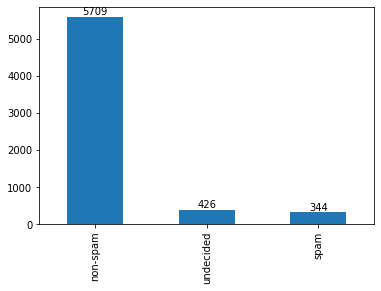

In [ ]:
#Analysis of target variable

graph_df = df["Label"].value_counts().rename({0:"non-spam", 1: "spam", 2:"undecided"})
print("Count for each label present (spam/non-spam/undecided)")
print(graph_df)
print()

ax = graph_df.plot.bar()
labels = [5709, 426, 344]
rects = ax.patches
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

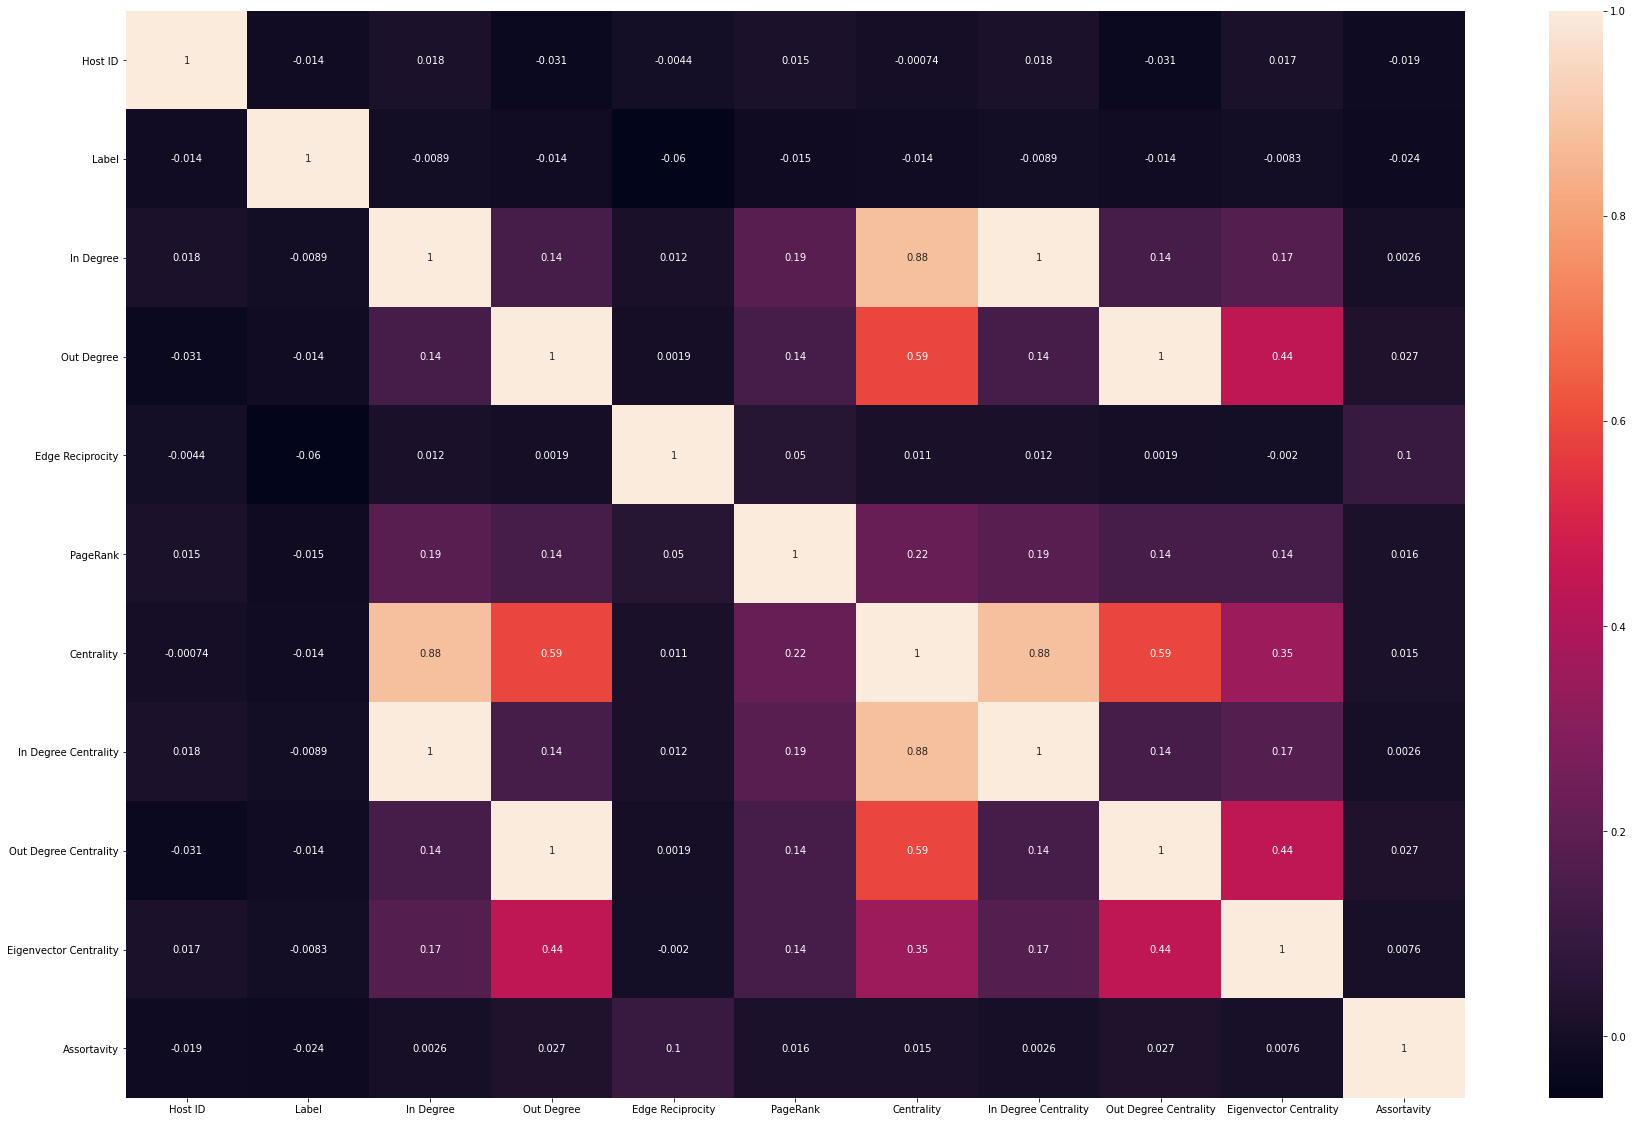

In [ ]:
#visualization through heatmap
import seaborn as sns

cm = df.corr()
plt.figure(figsize=(30,20))
_ = sns.heatmap(cm, annot=True)

In [ ]:
nonspam = df["Label"].value_counts()[0]
undecided = df["Label"].value_counts()[1]
spam = df["Label"].value_counts()[2]
total = nonspam+undecided+spam

print("Percentage of non-spam websites: {}%".format(round((nonspam*100/total), 3)))
print("Percentage of undecided websites: {}%".format(round((undecided*100/total), 3)))
print("Percentage of spam websites: {}%".format(round((spam*100/total), 3)))

#Dataset is unbalanced

Percentage of non-spam websites: 88.594%
Percentage of undecided websites: 5.083%
Percentage of spam websites: 6.322%


##Data classification

In [ ]:
#splitting into independent and dependent
X_train = train_df.drop(["Host ID", "Host Name", "Label"], axis=1, inplace=False)
y_train = train_df[["Label"]]
X_test = test_df.drop(["Host ID", "Host Name", "Label"], axis=1, inplace=False)
y_test = test_df[["Label"]]

print("Shapes of X_train and y_train are {} and {}".format(X_train.shape, y_train.shape))
print("Shapes of X_test and y_test are {} and {}".format(X_test.shape, y_test.shape))

Shapes of X_train and y_train are (4275, 8) and (4275, 1)
Shapes of X_test and y_test are (2204, 8) and (2204, 1)


In [ ]:
#balancing dataset
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
cross_validation_scores = pd.DataFrame(columns = ["Model", "Mean", "Standard Deviation"])
accuracies = pd.DataFrame(columns = ["Model", "Accuracy"])

In [ ]:
#Multiclass Support Vector Machine Classifier
svc_model = OneVsRestClassifier(SVC(C=200))
svc_model.fit(X_train, y_train)

scores = cross_val_score(svc_model, X_train, y_train, cv=5)
cross_validation_scores = cross_validation_scores.append({"Model":"Support Vector Machine Classifier", "Mean":scores.mean(), "Standard Deviation":scores.std()}, ignore_index=True )

y_pred = svc_model.predict(X_test)

svc_cm = confusion_matrix(y_test, y_pred)

svc_cr = classification_report(y_test, y_pred)

accuracies = accuracies.append({"Model":"Support Vector Machine Classifier", "Accuracy": accuracy_score(y_test, y_pred)*100}, ignore_index=True)

In [ ]:
#Multiclass Decision Tree Classifier
dtree_model = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy', splitter='best'))
dtree_model.fit(X_train, y_train)

scores = cross_val_score(dtree_model, X_train, y_train, cv=5)
cross_validation_scores = cross_validation_scores.append({"Model":"Decision Tree Classifier", "Mean":scores.mean(), "Standard Deviation":scores.std()}, ignore_index=True)

y_pred = dtree_model.predict(X_test)

dtree_cm = confusion_matrix(y_test, y_pred)

dtree_cr = classification_report(y_test, y_pred)

accuracies = accuracies.append({"Model":"Decision Tree Classifier", "Accuracy": accuracy_score(y_test, y_pred)*100}, ignore_index=True)

In [ ]:
#Multiclass Naive Bayes Classifier
nb_model = OneVsRestClassifier(DecisionTreeClassifier())
nb_model.fit(X_train, y_train)

scores = cross_val_score(nb_model, X_train, y_train, cv=5)
cross_validation_scores = cross_validation_scores.append({"Model":"Naive Bayes Classifier", "Mean":scores.mean(), "Standard Deviation":scores.std()}, ignore_index=True )

y_pred = nb_model.predict(X_test)

nb_cm = confusion_matrix(y_test, y_pred)

nb_cr = classification_report(y_test, y_pred)

accuracies = accuracies.append({"Model":"Naive Bayes Classifier", "Accuracy": accuracy_score(y_test, y_pred)*100}, ignore_index=True)

In [ ]:
#Multiclass KNN Classifier
knn_model = OneVsRestClassifier(DecisionTreeClassifier())
knn_model.fit(X_train, y_train)

scores = cross_val_score(knn_model, X_train, y_train, cv=5)
cross_validation_scores = cross_validation_scores.append({"Model":"KNN Classifier", "Mean":scores.mean(), "Standard Deviation":scores.std()}, ignore_index=True )

y_pred = knn_model.predict(X_test)

knn_cm = confusion_matrix(y_test, y_pred)

knn_cr = classification_report(y_test, y_pred)

accuracies = accuracies.append({"Model":"KNN Classifier", "Accuracy": accuracy_score(y_test, y_pred)*100}, ignore_index=True)

[[1072  198  663]
 [  50   19   53]
 [  44   21   84]]


In [ ]:
#Multiclass Random Forest Classifier
rf_model = OneVsRestClassifier(DecisionTreeClassifier())
rf_model.fit(X_train, y_train)

scores = cross_val_score(rf_model, X_train, y_train, cv=5)
cross_validation_scores = cross_validation_scores.append({"Model":"Random Forest Classifier", "Mean":scores.mean(), "Standard Deviation":scores.std()}, ignore_index=True )

y_pred = rf_model.predict(X_test)

rf_cm = confusion_matrix(y_test, y_pred)

rf_cr = classification_report(y_test, y_pred)

accuracies = accuracies.append({"Model":"Random Forest Classifier", "Accuracy": accuracy_score(y_test, y_pred)*100}, ignore_index=True)

In [ ]:
#Multiclass Stochastic Gradient Descent Classifier
sgd_model = OneVsRestClassifier(DecisionTreeClassifier())
sgd_model.fit(X_train, y_train)

scores = cross_val_score(sgd_model, X_train, y_train, cv=5)
cross_validation_scores = cross_validation_scores.append({"Model":"Stochastic Gradient Descent Classifier", "Mean":scores.mean(), "Standard Deviation":scores.std()}, ignore_index=True )

y_pred = sgd_model.predict(X_test)

sgd_cm = confusion_matrix(y_test, y_pred)

sgd_cr = classification_report(y_test, y_pred)

accuracies = accuracies.append({"Model":"Stochastic Gradient Descent Classifier", "Accuracy": accuracy_score(y_test, y_pred)*100}, ignore_index=True)

##Data Validation and Results Visualization

In [ ]:
#cross validation scores

cross_validation_scores

,Model,Mean,Standard Deviation
0,Support Vector Machine Classifier,0.410752,0.008658
1,Decision Tree Classifier,0.645482,0.015164
2,Naive Bayes Classifier,0.641068,0.015875
3,KNN Classifier,0.641510,0.017452
4,Random Forest Classifier,0.641422,0.017355
5,Stochastic Gradient Descent Classifier,0.642923,0.016058


In [ ]:
#accuracies

accuracies.sort_values(by="Accuracy", ascending=False, inplace=True)
accuracies

,Model,Accuracy
0,Support Vector Machine Classifier,71.960073
1,Decision Tree Classifier,54.355717
3,KNN Classifier,53.312160
5,Stochastic Gradient Descent Classifier,53.266788
2,Naive Bayes Classifier,53.176044
4,Random Forest Classifier,52.949183


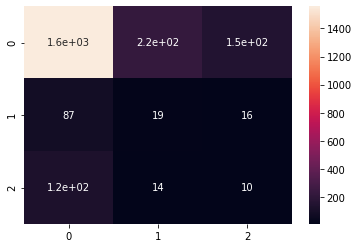

In [ ]:
#Confusion Matrices
import seaborn as sns

_ = sns.heatmap(svc_cm, annot=True)

In [ ]:
svc_cm

array([[1557,  225,  151],
       [  87,   19,   16],
       [ 125,   14,   10]])

In [ ]:
print(svc_cr)

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1933
           1       0.07      0.16      0.10       122
           2       0.06      0.07      0.06       149

    accuracy                           0.72      2204
   macro avg       0.34      0.34      0.33      2204
weighted avg       0.78      0.72      0.75      2204



# Phase 2 - with TrustRank

In [ ]:
#weighted adjacency list of graph g

from collections import defaultdict
edges = defaultdict(list)

for line in nx.generate_adjlist(g):
  split_line = line.split(' ')
  key = int(split_line[0])
  vertices = list(map(int, split_line[1:]))
  for vertex in vertices:
    w = g.get_edge_data(key, vertex)['weight']
    edges[key].append(list((vertex, w)))

edges

defaultdict(list,
            {0: [[1005, 1],
              [8306, 1],
              [9596, 1],
              [10056, 1],
              [10981, 1],
              [18571, 1],
              [22236, 1],
              [24284, 1],
              [26724, 3],
              [28431, 1],
              [30459, 1],
              [30842, 1],
              [34470, 1],
              [36763, 1],
              [39507, 1],
              [40559, 1],
              [40999, 1],
              [48883, 1],
              [59122, 1],
              [62009, 1],
              [62960, 1],
              [62966, 1],
              [67465, 1],
              [70094, 293],
              [70156, 1],
              [70627, 1],
              [72133, 1],
              [75781, 2],
              [75788, 1],
              [77202, 1],
              [78950, 1],
              [79822, 1],
              [82672, 1],
              [88136, 1],
              [90226, 1],
              [94068, 1],
              [96144, 1],
              [962

In [ ]:
#obtaining page rank vector

page_rank_vector = list(pagerank(g).values())

In [ ]:
#initializing constants

beta = 0.85
epsilon = 1e-6
MAX_ITERATIONS = 100
node_number_threshold = 100

In [ ]:
#get set of trusted pages

import math
import heapq

if num_hosts < node_number_threshold:
  ratio = 0.2
else:
  ratio = 0.002
trusted_set_size = int(math.ceil(num_hosts * ratio))

heaped_ranks = [(rank, node) for (node, rank) in enumerate(page_rank_vector)]
heapq._heapify_max(heaped_ranks)
trusted_pages = [heapq._heappop_max(heaped_ranks)[1] for _ in range(trusted_set_size)]

trusted_pages

[40999,
 5169,
 10990,
 19504,
 81634,
 39774,
 51107,
 40559,
 75781,
 42757,
 58631,
 77627,
 34406,
 54071,
 48290,
 80261,
 59870,
 10541,
 40612,
 27550,
 78913,
 6750,
 68475,
 40577,
 82999,
 56164,
 82281,
 106975,
 46184,
 60715,
 55297,
 77619,
 5056,
 59140,
 77582,
 10542,
 93618,
 98926,
 87406,
 93604,
 27108,
 102716,
 70416,
 32362,
 29512,
 11232,
 44157,
 5955,
 102454,
 72159,
 54141,
 43141,
 95168,
 93359,
 713,
 79389,
 68983,
 16015,
 87505,
 107471,
 58593,
 62302,
 79736,
 78905,
 46551,
 107976,
 45575,
 100086,
 51173,
 21206,
 90540,
 80862,
 45682,
 52518,
 81983,
 80886,
 27135,
 20077,
 38876,
 110562,
 51114,
 104357,
 53133,
 10960,
 109779,
 68339,
 67966,
 93364,
 5467,
 21150,
 58261,
 61630,
 109777,
 87720,
 97128,
 42665,
 106455,
 88136,
 10898,
 34780,
 85569,
 25028,
 78947,
 8187,
 114437,
 78345,
 62187,
 71305,
 43114,
 94824,
 37669,
 39355,
 5174,
 22215,
 46909,
 64029,
 26724,
 81561,
 10033,
 102203,
 79689,
 89964,
 65466,
 67936,
 330

In [ ]:
	def get_topicSpecificRank(self, teleport_set):
		diff = math.inf
		iterations = 0
		teleport_set_size = len(teleport_set)

		pg = plotGraph(self.edges, interval=3000)

		final_rank_vector = np.zeros(self.node_num)
		initial_rank_vector = np.fromiter(
			[1/teleport_set_size if node in teleport_set else 0 for node in
				range(self.node_num)], dtype='float')

		while(iterations < self.MAX_ITERATIONS and diff > self.epsilon):
			new_rank_vector = np.zeros(self.node_num)
			for parent in self.edges:
				for child in self.edges[parent]:
					new_rank_vector[child] += (initial_rank_vector[parent] /
						len(self.edges[parent]))

			leaked_rank = (1 - sum(new_rank_vector)) / teleport_set_size
			leaked_rank_vector = np.array([leaked_rank if node in teleport_set
				else 0 for node in range(self.node_num)])

			final_rank_vector = new_rank_vector + leaked_rank_vector
			diff = sum(abs(final_rank_vector - initial_rank_vector))
			initial_rank_vector = final_rank_vector

			iterations += 1
			print("TrustRank iteration: " + str(iterations))
			print(final_rank_vector)
			pg.plot(9, final_rank_vector)

		return final_rank_vector

In [ ]:
#Topic Specific Rank computation
#teleport set is the set of trusted pages (trusted_pages)

diff = math.inf
iterations = 0
teleport_set_size = len(trusted_pages)

final_rank_vector = np.zeros(num_hosts)

initial_rank_vector = np.fromiter([1/teleport_set_size if node in trusted_pages else 0 for node in range(num_hosts)], dtype='float')

while(iterations < MAX_ITERATIONS and diff > epsilon):
  new_rank_vector = np.zeros(num_hosts)
  for parent in edges:
    for child, weight in edges[parent]:
      new_rank_vector[child] += (initial_rank_vector[parent] / sum([w for c,w in edges[parent]]))

  leaked_rank = (1 - sum(new_rank_vector)) / teleport_set_size
  leaked_rank_vector = np.array([leaked_rank if node in trusted_pages else 0 for node in range(num_hosts)])

  final_rank_vector = new_rank_vector + leaked_rank_vector
  diff = sum(abs(final_rank_vector - initial_rank_vector))
  initial_rank_vector = final_rank_vector

  iterations += 1
  print(iterations)

final_rank_vector

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [ ]:
#trustrank output

n = 0
trustrank = {}
for rank in final_rank_vector:
  trustrank[n] = rank
  n += 1